In [1]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
#from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms

from PIL import Image
from IPython.display import Image 



In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [3]:
batch_size = 10

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [ ]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, labels = next(iter(train_loader_CE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


In [4]:
batch_size = 10

In [5]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)

    

    

In [6]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")
train_loader_CE = torch.utils.data.DataLoader(dsetCE, shuffle=True, batch_size=batch_size)
dsetCE.__len__()

150

In [7]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

In [16]:
# Cellular automata class
class CAModel(nn.Module):

    def __init__(self, channel_n, fire_rate=0.5, device=torch.device("cpu")):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n        

        self.fire_rate = fire_rate
        self.to(self.device)
        
        self.conv0 = nn.Conv2d(45, 1, kernel_size=px_size)
        self.conv1 = nn.Conv2d(46, 34, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(34, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 6, kernel_size=1)
        
        self.prewitt_x = torch.FloatTensor([[1,0,-1],[1,0,-1],[1,0,-1]]).to(dev)
        self.prewitt_y = torch.FloatTensor([[1,1,1],[0,0,0],[-1,-1,-1]]).to(dev)
        
        self.sobel_x = torch.FloatTensor([[1,0,-1],[2,0,-2],[1,0,-1]]).to(dev)
        self.sobel_y = torch.FloatTensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(dev)
        
    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 sobel operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalise these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with the 4 of these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)

        # Concatenate: x (6 channels), 4 sobel filters (6 channels each), max pool (6 channels) = 36 total
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y
    
    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach().transpose(0,1)[3:9])
                b0 = self.perceive(x, 0)
                b1 = self.conv0(b0)
                b10 = torch.zeros(batch_size, 1, px_size, px_size).to(dev) + b1
                b2 = torch.cat((b0, b10), dim=1)
                b3 = self.conv3((self.conv2(self.relu(self.conv1(b2)))))

                c = x.detach().clone()
                stochastic = torch.rand([b3.size(0),b3.size(1),b3.size(2),b3.size(3)])>self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = b3*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b0 = self.perceive(x, 0)
                b1 = self.conv0(b0)
                b10 = torch.zeros(batch_size, 1, px_size, px_size).to(dev) + b1
                b2 = torch.cat((b0, b10), dim=1)
                b3 = self.conv3((self.conv2(self.relu(self.conv1(b2)))))

                c = x.detach().clone()
                stochastic = torch.rand([b3.size(0),b3.size(1),b3.size(2),b3.size(3)])>self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = b3*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [17]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([2,1, 1.05, 8.9, 9, 8.8]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=w, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
#loss = FocalLoss()
loss_mse = []
loss_ce = []
history = []
epochs = 250

batch_size=10

In [ ]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

In [ ]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs:
        last = True
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        #out = loss1(b,c) + 4*loss1(b[3],c[3])+15*loss1(b[4],c[4])+4*loss1(b[5],c[5])
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
    scheduler.step()

In [19]:
torch.save(model, 'misc_figures/global.pth')

torch.Size([60, 60, 4])


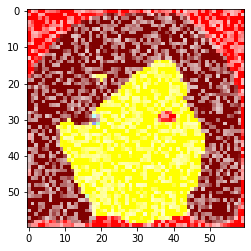

In [15]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [39]:
# Save final iterations as gif

epoch_new = [ts(i) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

# DICE Score
def dice(pred, target, epsilon=1e-6):
    y_true_flatten = np.asarray(target.cpu()).astype(np.bool)
    y_pred_flatten = np.asarray(pred.cpu()).astype(np.bool)

    if not np.sum(y_true_flatten) + np.sum(y_pred_flatten):
        return 1.0

    return (2. * np.sum(y_true_flatten * y_pred_flatten)) /\
           (np.sum(y_true_flatten) + np.sum(y_pred_flatten) + epsilon)

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [13]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.7118, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


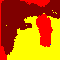

1.7117763757705688
Loss = tensor(1.5014, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


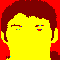

1.5013887882232666
Loss = tensor(1.4528, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


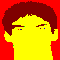

1.452806830406189
Loss = tensor(1.5163, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


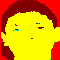

1.5162779092788696
Loss = tensor(1.4939, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


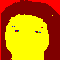

1.4939030408859253
Loss = tensor(1.4518, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


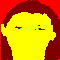

1.4517555236816406
Loss = tensor(1.4702, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


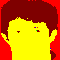

1.4702038764953613
Loss = tensor(1.4840, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


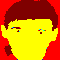

1.4839794635772705
Loss = tensor(1.5081, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


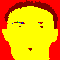

1.5080593824386597
Loss = tensor(1.5539, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


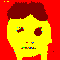

1.5539296865463257
Loss = tensor(1.4593, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


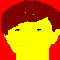

1.4593110084533691
Loss = tensor(1.5114, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


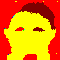

1.5114126205444336
Loss = tensor(1.4688, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


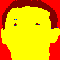

1.4687875509262085
Loss = tensor(1.4956, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


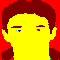

1.495639681816101
Loss = tensor(1.4771, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


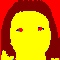

1.4771076440811157
Loss = tensor(1.4384, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


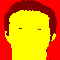

1.438395380973816
Loss = tensor(1.5227, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


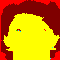

1.5227168798446655
Loss = tensor(1.5446, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


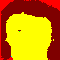

1.5446181297302246
Loss = tensor(1.4738, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


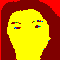

1.4737904071807861
Loss = tensor(1.4804, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


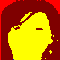

1.4803895950317383
Loss = tensor(1.4680, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


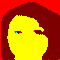

1.4679539203643799
Loss = tensor(1.5180, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


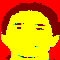

1.5180424451828003
Loss = tensor(1.4816, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


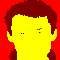

1.48159921169281
Loss = tensor(1.5637, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


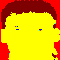

1.5637059211730957
Loss = tensor(1.4621, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


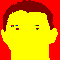

1.4621357917785645
Loss = tensor(1.4437, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


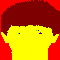

1.4436614513397217
Loss = tensor(1.4616, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


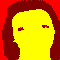

1.4615554809570312
Loss = tensor(1.4846, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


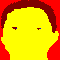

1.4845584630966187
Loss = tensor(1.4792, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


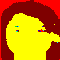

1.4791767597198486
Loss = tensor(1.4657, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


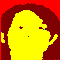

1.4656665325164795


In [14]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [16]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/global_p.npy', boxplot_p)
np.save('metrics/global_r.npy', boxplot_r)
np.save('metrics/global_a.npy', boxplot_a)
np.save('metrics/global_s.npy', boxplot_s)
np.save('metrics/global_m.npy', boxplot_mi)
np.save('metrics/global_dice.npy', dice_list)

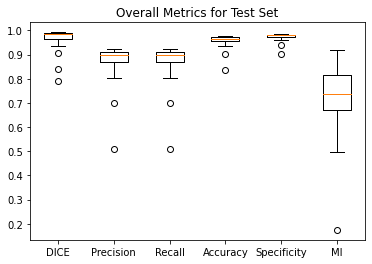

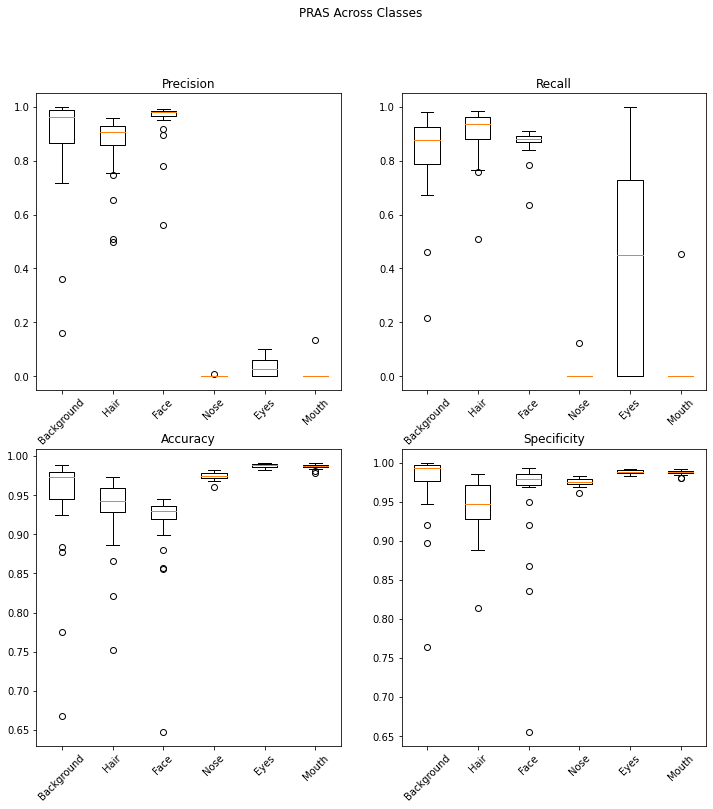

In [17]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1GlobalPras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("pras/1GlobalPrasClass.png")

In [30]:
np.save('dice_global.npy', dice_list)